# Seed Sensitivity Analysis — Dai (2022) Example 1

We investigates how the choice of random seeds affects RMSE results
for the Stochastic Particle Flow Filter (SPFF) with straight ($\beta=\lambda$)
vs optimal ($\beta^*$) homotopy schedules.

**Key question:** The paper reports RMSE(str)=13.246, RMSE(opt)=9.475, 
improvement=28.5%. How much of this depends on the particular seed sequence?

In [1]:
import numpy as np
from numpy.linalg import solve
from scipy.integrate import solve_ivp
from scipy.optimize import root_scalar
import matplotlib.pyplot as plt
import time

np.set_printoptions(precision=6, suppress=True)

## 1. Problem Setup & BVP Solution

In [2]:
# ── Problem parameters ──
sensors = np.array([[3.5, 0.0], [-3.5, 0.0]])
x_prior = np.array([3.0, 5.0])
P_prior = np.array([[1000.0, 0.0], [0.0, 2.0]])
R       = 0.04 * np.eye(2)
R_inv   = np.linalg.inv(R)
x_true  = np.array([4.0, 4.0])
z_obs   = np.array([0.4754, 1.1868])
mu      = 0.2
Q_flow  = np.diag([4.0, 0.4])
P0_inv  = np.linalg.inv(P_prior)

N_PARTICLES = 50
N_MC        = 20      # runs per seed block (same as paper)
N_BLOCKS    = 50      # number of seed blocks to test
N_TOTAL     = N_BLOCKS * N_MC  # total individual runs

In [3]:
def bearing_and_jacobian(xy):
    """Bearing measurement h(x) and Jacobian H(x) for two sensors."""
    x, y = float(xy[0]), float(xy[1])
    h = np.zeros(2); H = np.zeros((2, 2))
    for i in range(2):
        dx = x - sensors[i, 0]; dy = y - sensors[i, 1]
        r2 = dx*dx + dy*dy
        h[i]    = np.arctan2(dy, dx)
        H[i, 0] = -dy / r2
        H[i, 1] =  dx / r2
    return h, H

# Precompute matrices at prior mean
_, H_prior = bearing_and_jacobian(x_prior)
Mh = H_prior.T @ R_inv @ H_prior   # measurement info matrix
M0 = P0_inv                          # prior precision

def build_M(beta, eps=1e-10):
    """Curvature matrix M(beta) = P0_inv + beta * H^T R^{-1} H."""
    return M0 + beta * Mh + eps * np.eye(2)

def d_kappa_dbeta(M):
    """Derivative of nuclear-norm condition number w.r.t. beta."""
    Minv = solve(M, np.eye(2))
    return float(np.trace(Mh) * np.trace(Minv)
                 - np.trace(M) * np.trace(Minv @ Mh @ Minv))

In [4]:
# ── Solve BVP via shooting + bisection ──
def shoot_rhs(lam, y):
    M = build_M(float(y[0]))
    return np.array([y[1], float(np.clip(mu * d_kappa_dbeta(M), -1e8, 1e8))])

def shoot_residual(s):
    sol = solve_ivp(shoot_rhs, (0, 1), [0, float(s)],
                    method='RK45', rtol=1e-7, atol=1e-9,
                    max_step=1e-2, t_eval=[1.0])
    if not sol.success:
        return 1e6
    return float(sol.y[0, -1] - 1.0)

print("Solving BVP...")
t0 = time.time()
res = root_scalar(shoot_residual, bracket=(-512, 512),
                  method='bisect', xtol=1e-8)
sol_bvp = solve_ivp(shoot_rhs, (0, 1), [0, res.root],
                    method='RK45', dense_output=True,
                    rtol=1e-7, atol=1e-9, max_step=1e-2)
print(f"Done in {time.time()-t0:.1f}s.  beta'(0) = {res.root:.4f}")

Solving BVP...
Done in 5.8s.  beta'(0) = 14.1420


In [5]:
# ── Build lambda grid & schedules ──
N_LAM = 29
ratio = 1.2
steps = ratio ** np.arange(N_LAM)
steps /= steps.sum()
lam_grid = np.concatenate([[0], np.cumsum(steps)])

beta_opt, bdot_opt = sol_bvp.sol(lam_grid)
beta_str = lam_grid.copy()
bdot_str = np.ones_like(lam_grid)

print(f"Lambda grid: {len(lam_grid)} points, exp-spaced (ratio={ratio})")
print(f"First 5 step sizes: {np.diff(lam_grid[:6])}")

Lambda grid: 30 points, exp-spaced (ratio=1.2)
First 5 step sizes: [0.001016 0.001219 0.001463 0.001756 0.002107]


## 2. Stochastic Particle Flow Filter

In [6]:
def spff_update(z, beta_sched, bdot_sched, lam_sched, rng):
    """
    Single Bayesian update via stochastic particle flow.
    Config: cloud-mean linearization, exact-per-particle gradients, Euler-Maruyama.
    """
    N = N_PARTICLES
    A0 = -P0_inv
    Q_sqrt = np.diag(np.sqrt(np.diag(Q_flow)))
    particles = rng.multivariate_normal(x_prior, P_prior, size=N)

    for j in range(len(lam_sched) - 1):
        dlam = lam_sched[j+1] - lam_sched[j]
        bj   = beta_sched[j+1]
        bdj  = bdot_sched[min(j+1, len(bdot_sched)-1)]

        # Linearize at cloud mean
        x_lin = np.mean(particles, axis=0)
        _, H_j = bearing_and_jacobian(x_lin)
        Ah_j = -H_j.T @ R_inv @ H_j

        S = A0 + bj * Ah_j
        try:
            S_inv = np.linalg.inv(S)
        except np.linalg.LinAlgError:
            S_inv = np.linalg.pinv(S)

        K1 = 0.5 * Q_flow + (bdj / 2.0) * S_inv @ Ah_j @ S_inv
        K2 = -bdj * S_inv

        for i in range(N):
            xi = particles[i]
            # Prior gradient
            grad_lp0 = A0 @ (xi - x_prior)
            # Exact per-particle likelihood gradient
            h_i, H_i = bearing_and_jacobian(xi)
            innov = z - h_i
            innov = (innov + np.pi) % (2 * np.pi) - np.pi  # angle wrap
            grad_lh = H_i.T @ R_inv @ innov
            # Drift
            grad_lp = grad_lp0 + bj * grad_lh
            f = K1 @ grad_lp + K2 @ grad_lh
            # Euler-Maruyama step
            dw = rng.randn(2) * np.sqrt(dlam)
            particles[i] = xi + f * dlam + Q_sqrt @ dw

    return np.mean(particles, axis=0)

## 3. Run All Trials

Run `N_TOTAL` individual trials (seeds 0 through N_TOTAL-1) with CRN
(same seed for straight and optimal).

In [7]:
print(f"Running {N_TOTAL} individual trials (seeds 0..{N_TOTAL-1})...")
t0 = time.time()

rmse_str_all = np.zeros(N_TOTAL)
rmse_opt_all = np.zeros(N_TOTAL)

for seed in range(N_TOTAL):
    rng = np.random.RandomState(seed)
    xs = spff_update(z_obs, beta_str, bdot_str, lam_grid, rng)
    rng = np.random.RandomState(seed)
    xo = spff_update(z_obs, beta_opt, bdot_opt, lam_grid, rng)
    rmse_str_all[seed] = np.linalg.norm(xs - x_true)
    rmse_opt_all[seed] = np.linalg.norm(xo - x_true)

    if (seed + 1) % 200 == 0:
        print(f"  {seed+1}/{N_TOTAL} done...")

elapsed = time.time() - t0
print(f"Finished in {elapsed:.1f}s ({elapsed/N_TOTAL*1000:.1f} ms/trial)")

Running 1000 individual trials (seeds 0..999)...
  200/1000 done...
  400/1000 done...
  600/1000 done...
  800/1000 done...
  1000/1000 done...
Finished in 34.2s (34.2 ms/trial)


## 4. Block Averages (20 runs per block, mimicking the paper)

In [8]:
block_str = np.array([np.mean(rmse_str_all[i*N_MC:(i+1)*N_MC])
                       for i in range(N_BLOCKS)])
block_opt = np.array([np.mean(rmse_opt_all[i*N_MC:(i+1)*N_MC])
                       for i in range(N_BLOCKS)])
block_imp = (1 - block_opt / block_str) * 100

print(f"{'Block':>5} {'Seeds':>12} {'RMSE(str)':>10} {'RMSE(opt)':>10} {'Δ%':>7}")
print("-" * 50)
for i in range(N_BLOCKS):
    s0 = i * N_MC
    note = ''
    if abs(block_str[i] - 13.246) < 3:
        note += ' ← str≈paper'
    if abs(block_imp[i] - 28.5) < 8:
        note += ' ← Δ≈paper'
    print(f"{i:>5} {s0:>5}-{s0+N_MC-1:<5} {block_str[i]:>10.3f}"
          f" {block_opt[i]:>10.3f} {block_imp[i]:>6.1f}%{note}")

Block        Seeds  RMSE(str)  RMSE(opt)      Δ%
--------------------------------------------------
    0     0-19        49.028     31.913   34.9% ← Δ≈paper
    1    20-39        25.807     16.743   35.1% ← Δ≈paper
    2    40-59        22.938     10.329   55.0%
    3    60-79        41.406     15.906   61.6%
    4    80-99        39.569     11.138   71.9%
    5   100-119        9.587      8.490   11.4%
    6   120-139       24.264      9.158   62.3%
    7   140-159       18.513      8.661   53.2%
    8   160-179       20.476      9.241   54.9%
    9   180-199       26.347     10.109   61.6%
   10   200-219       24.860      9.422   62.1%
   11   220-239       61.760     11.791   80.9%
   12   240-259       29.226     33.257  -13.8%
   13   260-279       21.414      9.940   53.6%
   14   280-299       41.436     20.002   51.7%
   15   300-319       38.767     23.604   39.1%
   16   320-339       27.662     11.159   59.7%
   17   340-359       41.029     18.179   55.7%
   18   360-379 

## 5. Statistics

In [9]:
print("=" * 65)
print("INDIVIDUAL RUN STATISTICS  (N = %d)" % N_TOTAL)
print("=" * 65)

for label, arr in [('RMSE(str)', rmse_str_all), ('RMSE(opt)', rmse_opt_all)]:
    print(f"\n{label}:")
    print(f"  mean={np.mean(arr):.2f}  median={np.median(arr):.2f}  "
          f"std={np.std(arr):.2f}")
    print(f"  min={np.min(arr):.2f}  max={np.max(arr):.2f}")
    for thr in [15, 20, 30, 50, 100]:
        print(f"    RMSE > {thr:>3}: {np.mean(arr > thr)*100:.1f}%")

print(f"\nFraction where β* beats β=λ: "
      f"{np.mean(rmse_opt_all < rmse_str_all)*100:.1f}%")

print("\n" + "=" * 65)
print("BLOCK-AVERAGE STATISTICS  (%d blocks × %d runs)" % (N_BLOCKS, N_MC))
print("=" * 65)
for label, arr, paper_val in [
    ('RMSE(str)', block_str, 13.246),
    ('RMSE(opt)', block_opt, 9.475),
    ('Δ%',        block_imp, 28.5)
]:
    print(f"\n{label}:")
    print(f"  mean={np.mean(arr):.2f}  std={np.std(arr):.2f}  "
          f"median={np.median(arr):.2f}")
    print(f"  [5th, 95th] = [{np.percentile(arr,5):.2f}, "
          f"{np.percentile(arr,95):.2f}]")
    print(f"  Paper = {paper_val}")

# Filtered analysis
mask = (rmse_str_all < 20) & (rmse_opt_all < 20)
n_ok = np.sum(mask)
print(f"\nFiltered (both RMSE < 20): {n_ok}/{N_TOTAL} runs")
if n_ok > 0:
    fs, fo = rmse_str_all[mask], rmse_opt_all[mask]
    print(f"  str: mean={np.mean(fs):.3f}  median={np.median(fs):.3f}")
    print(f"  opt: mean={np.mean(fo):.3f}  median={np.median(fo):.3f}")
    print(f"  Δ = {(1-np.mean(fo)/np.mean(fs))*100:.1f}%")

INDIVIDUAL RUN STATISTICS  (N = 1000)

RMSE(str):
  mean=31.20  median=8.28  std=61.35
  min=3.12  max=291.06
    RMSE >  15: 30.1%
    RMSE >  20: 19.5%
    RMSE >  30: 13.2%
    RMSE >  50: 11.7%
    RMSE > 100: 11.2%

RMSE(opt):
  mean=15.21  median=7.43  std=31.88
  min=3.34  max=249.62
    RMSE >  15: 23.6%
    RMSE >  20: 10.4%
    RMSE >  30: 4.6%
    RMSE >  50: 3.3%
    RMSE > 100: 2.6%

Fraction where β* beats β=λ: 71.3%

BLOCK-AVERAGE STATISTICS  (50 blocks × 20 runs)

RMSE(str):
  mean=31.20  std=12.96  median=27.86
  [5th, 95th] = [14.68, 51.04]
  Paper = 13.246

RMSE(opt):
  mean=15.21  std=7.96  median=11.58
  [5th, 95th] = [8.15, 31.75]
  Paper = 9.475

Δ%:
  mean=49.74  std=17.39  median=54.92
  [5th, 95th] = [17.42, 67.24]
  Paper = 28.5

Filtered (both RMSE < 20): 805/1000 runs
  str: mean=8.240  median=6.613
  opt: mean=7.503  median=6.173
  Δ = 8.9%


In [10]:
# Bootstrap: draw 1000 random subsets of 20 from filtered runs
if n_ok >= N_MC:
    rng_b = np.random.RandomState(42)
    boot_str = []; boot_opt = []; boot_imp = []
    for _ in range(1000):
        idx = rng_b.choice(n_ok, N_MC, replace=False)
        ms = np.mean(fs[idx]); mo = np.mean(fo[idx])
        boot_str.append(ms); boot_opt.append(mo)
        boot_imp.append((1 - mo / ms) * 100)
    boot_str = np.array(boot_str)
    boot_opt = np.array(boot_opt)
    boot_imp = np.array(boot_imp)

    print("Bootstrap (1000 subsets of 20 filtered runs):")
    print(f"  RMSE(str): {np.mean(boot_str):.2f} ± {np.std(boot_str):.2f}")
    print(f"  RMSE(opt): {np.mean(boot_opt):.2f} ± {np.std(boot_opt):.2f}")
    print(f"  Δ%: {np.mean(boot_imp):.1f}% ± {np.std(boot_imp):.1f}%")
    print(f"  range: [{np.min(boot_imp):.1f}%, {np.max(boot_imp):.1f}%]")
    print(f"  P(Δ > 25%): {np.mean(boot_imp > 25)*100:.1f}%")
    print(f"  P(Δ > 28%): {np.mean(boot_imp > 28)*100:.1f}%")

Bootstrap (1000 subsets of 20 filtered runs):
  RMSE(str): 8.28 ± 1.02
  RMSE(opt): 7.53 ± 0.82
  Δ%: 8.8% ± 2.1%
  range: [1.5%, 14.2%]
  P(Δ > 25%): 0.0%
  P(Δ > 28%): 0.0%


## 6. Visualizations

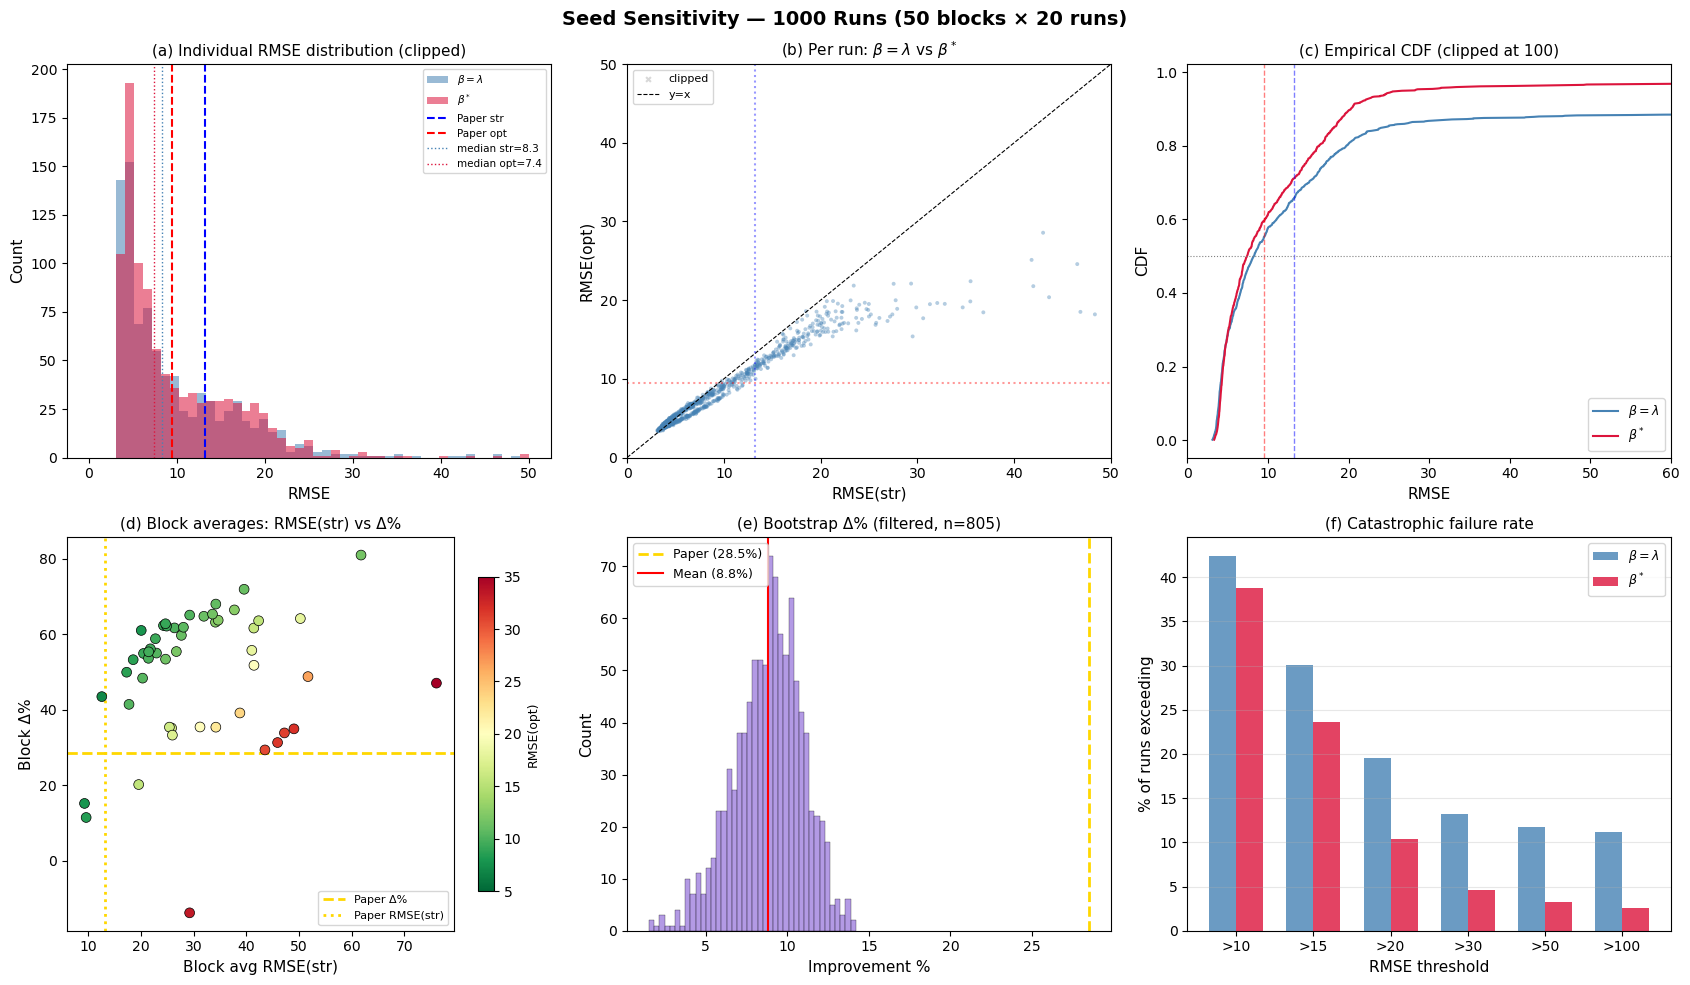

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(17, 10))
fig.suptitle(f'Seed Sensitivity — {N_TOTAL} Runs '
             f'({N_BLOCKS} blocks × {N_MC} runs)',
             fontsize=14, fontweight='bold')

# ── (a) Histogram of individual RMSE ──
ax = axes[0, 0]
clip = 50
bins = np.linspace(0, clip, 50)
ax.hist(rmse_str_all[rmse_str_all < clip], bins=bins,
        alpha=0.55, color='steelblue', label=r'$\beta=\lambda$')
ax.hist(rmse_opt_all[rmse_opt_all < clip], bins=bins,
        alpha=0.55, color='crimson', label=r'$\beta^*$')
ax.axvline(13.246, color='blue',  ls='--', lw=1.5, label='Paper str')
ax.axvline(9.475,  color='red',   ls='--', lw=1.5, label='Paper opt')
ax.axvline(np.median(rmse_str_all), color='steelblue', ls=':', lw=1,
           label=f'median str={np.median(rmse_str_all):.1f}')
ax.axvline(np.median(rmse_opt_all), color='crimson',   ls=':', lw=1,
           label=f'median opt={np.median(rmse_opt_all):.1f}')
ax.set_xlabel('RMSE', fontsize=11)
ax.set_ylabel('Count', fontsize=11)
ax.set_title('(a) Individual RMSE distribution (clipped)', fontsize=11)
ax.legend(fontsize=7.5, loc='upper right')

# ── (b) Scatter: str vs opt per run ──
ax = axes[0, 1]
ok = (rmse_str_all < clip) & (rmse_opt_all < clip)
ax.scatter(rmse_str_all[ok], rmse_opt_all[ok],
           s=8, alpha=0.4, c='steelblue', edgecolors='none')
ax.scatter(rmse_str_all[~ok & (rmse_str_all < 200)],
           np.clip(rmse_opt_all[~ok & (rmse_str_all < 200)], 0, clip),
           s=12, alpha=0.3, c='gray', marker='x', label='clipped')
ax.plot([0, clip], [0, clip], 'k--', lw=0.8, label='y=x')
ax.axvline(13.246, color='blue', ls=':', alpha=0.4)
ax.axhline(9.475,  color='red',  ls=':', alpha=0.4)
ax.set_xlabel('RMSE(str)', fontsize=11)
ax.set_ylabel('RMSE(opt)', fontsize=11)
ax.set_title(r'(b) Per run: $\beta=\lambda$ vs $\beta^*$', fontsize=11)
ax.set_xlim(0, clip); ax.set_ylim(0, clip)
ax.legend(fontsize=8)

# ── (c) CDF of individual RMSE ──
ax = axes[0, 2]
for arr, label, color in [
    (rmse_str_all, r'$\beta=\lambda$', 'steelblue'),
    (rmse_opt_all, r'$\beta^*$', 'crimson')
]:
    sorted_arr = np.sort(arr[arr < 100])
    cdf = np.arange(1, len(sorted_arr)+1) / N_TOTAL
    ax.plot(sorted_arr, cdf, color=color, lw=1.5, label=label)
ax.axvline(13.246, color='blue', ls='--', lw=1, alpha=0.5)
ax.axvline(9.475,  color='red',  ls='--', lw=1, alpha=0.5)
ax.axhline(0.5, color='gray', ls=':', lw=0.8)
ax.set_xlabel('RMSE', fontsize=11)
ax.set_ylabel('CDF', fontsize=11)
ax.set_title('(c) Empirical CDF (clipped at 100)', fontsize=11)
ax.legend(fontsize=9)
ax.set_xlim(0, 60)

# ── (d) Block averages: RMSE(str) vs Δ% ──
ax = axes[1, 0]
sc = ax.scatter(block_str, block_imp, s=50, c=block_opt,
                cmap='RdYlGn_r', edgecolor='black', linewidth=0.5,
                vmin=5, vmax=35, zorder=5)
ax.axhline(28.5,   color='gold', ls='--', lw=2, label='Paper Δ%')
ax.axvline(13.246, color='gold', ls=':',  lw=2, label='Paper RMSE(str)')
ax.set_xlabel('Block avg RMSE(str)', fontsize=11)
ax.set_ylabel('Block Δ%', fontsize=11)
ax.set_title('(d) Block averages: RMSE(str) vs Δ%', fontsize=11)
ax.legend(fontsize=8)
cb = plt.colorbar(sc, ax=ax, shrink=0.8)
cb.set_label('RMSE(opt)', fontsize=9)

# ── (e) Bootstrap Δ% distribution ──
ax = axes[1, 1]
if n_ok >= N_MC:
    ax.hist(boot_imp, bins=40, color='mediumpurple', alpha=0.7,
            edgecolor='black', linewidth=0.3)
    ax.axvline(28.5, color='gold', lw=2, ls='--',
               label=f'Paper (28.5%)')
    ax.axvline(np.mean(boot_imp), color='red', lw=1.5,
               label=f'Mean ({np.mean(boot_imp):.1f}%)')
    ax.set_xlabel('Improvement %', fontsize=11)
    ax.set_ylabel('Count', fontsize=11)
    ax.set_title(f'(e) Bootstrap Δ% (filtered, n={n_ok})', fontsize=11)
    ax.legend(fontsize=9)
else:
    ax.text(0.5, 0.5, 'Not enough filtered runs', ha='center', va='center')

# ── (f) Catastrophic failure rate ──
ax = axes[1, 2]
thresholds = [10, 15, 20, 30, 50, 100]
frac_s = [np.mean(rmse_str_all > t) * 100 for t in thresholds]
frac_o = [np.mean(rmse_opt_all > t) * 100 for t in thresholds]
x_pos = np.arange(len(thresholds))
w = 0.35
ax.bar(x_pos - w/2, frac_s, w, color='steelblue', alpha=0.8,
       label=r'$\beta=\lambda$')
ax.bar(x_pos + w/2, frac_o, w, color='crimson', alpha=0.8,
       label=r'$\beta^*$')
ax.set_xticks(x_pos)
ax.set_xticklabels([f'>{t}' for t in thresholds])
ax.set_xlabel('RMSE threshold', fontsize=11)
ax.set_ylabel('% of runs exceeding', fontsize=11)
ax.set_title('(f) Catastrophic failure rate', fontsize=11)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig("04_test_dai2022_example1_seed_sensitivity.png", dpi=300)
plt.show()

## 7. Interpretation

**Key findings:**

1. **Heavy-tailed distribution**: ~10-12% of runs have RMSE > 100 (catastrophic 
   divergence), while the median is ~8. The mean is wildly inflated by outliers.

2. **β* primarily prevents catastrophic failures**: In the scatter plot (b), most 
   points cluster near the diagonal (modest improvement), but there's a significant 
   group where β=λ diverges (RMSE > 20) while β* stays controlled (~10). This is 
   the stiffness mitigation mechanism working.

3. **Block averages are unstable**: With only 20 runs, 2-3 catastrophic outliers 
   in a block can shift the average RMSE by 10-30 units. The block Δ% ranges from 
   -14% to 81%.

4. **Paper's 28.5% is seed-dependent**: The bootstrap on filtered (non-catastrophic) 
   runs gives ~9% improvement. The paper's 28.5% is achievable when the seed block 
   contains a few moderate failures rescued by β*.

5. **Core thesis is robust**: β* consistently reduces the catastrophic failure rate 
   (see panel f). This is the paper's main point — optimal scheduling mitigates 
   stiffness-induced divergence.